**Mask-RCNN Starter Model for the SIIM-ACR Pneumothorax Segmentation with transfer learning **

This kernel uses pre-trained weights from a past medical imaging competition on pneumonia identification: https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155

Basic ideas included here:
* dataset distribution balancing
* image augmentation
* multi-stage training for transfer learning, and model weights analysis
* multi-mask prediction for submission

If you please, upvote and leave questions or constructive feedback below (for me and other kagglers learning).
Cheers!

In [1]:
debug = False
# debug = True

!ls ../input/

mask-rcnn-and-coco-transfer-learning-lb-0-155
siim-acr-pneumothorax-segmentation
siim-acr-pneumothorax-segmentation-data


In [2]:
import warnings 
warnings.filterwarnings("ignore")

import os, gc
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm, tqdm_notebook
import pandas as pd 
import glob

sys.path.insert(0, '/kaggle/input/siim-acr-pneumothorax-segmentation')
from mask_functions import rle2mask, mask2rle

In [3]:
DATA_DIR = '/kaggle/input/siim-acr-pneumothorax-segmentation-data/pneumothorax'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

!ls {DATA_DIR}

dicom-images-test  dicom-images-train  train-rle.csv


## Install Matterport's Mask-RCNN
A very popular model in github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [4]:
# !pip install 'keras==2.1.6' --force-reinstall
STAGE_DIR = '/tmp/Mask_RCNN'
!git clone https://www.github.com/matterport/Mask_RCNN.git {STAGE_DIR}
os.chdir(STAGE_DIR)
#!python setup.py -q install
!rm .git samples images assets -rf
!pwd; ls

Cloning into '/tmp/Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.90 MiB | 51.93 MiB/s, done.
Resolving deltas: 100% (571/571), done.
/tmp/Mask_RCNN
LICENSE  MANIFEST.in  README.md  mrcnn	requirements.txt  setup.cfg  setup.py


In [5]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
train_dicom_dir = os.path.join(DATA_DIR, 'dicom-images-train')
test_dicom_dir = os.path.join(DATA_DIR, 'dicom-images-test')

# count files
!ls -m {train_dicom_dir} | wc
!ls -m {test_dicom_dir} | wc

  10712   10712  604132
   1377    1377   76822


### Load Pneumonia pre-trained weights

In [7]:
# get model with best validation score: https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155/
WEIGHTS_PATH = "mask_rcnn_pneumonia.h5"
!cp /kaggle/input/mask-rcnn*/pneumonia*/*0013.h5 {WEIGHTS_PATH}
!du -sh *.h5

172M	mask_rcnn_pneumonia.h5


## Setup Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [8]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal

IMAGE_DIM = 512

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'Pneumothorax'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 11
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and pneumothorax classes
    
    IMAGE_MIN_DIM = IMAGE_DIM
    IMAGE_MAX_DIM = IMAGE_DIM
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 15
    DETECTION_MAX_INSTANCES = 4
    DETECTION_MIN_CONFIDENCE = 0.90
    DETECTION_NMS_THRESHOLD = 0.1
    WEIGHT_DECAY = 0.0005

    STEPS_PER_EPOCH = 20 if debug else 350
    VALIDATION_STEPS = 10 if debug else 120
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 12.0,
        "rpn_bbox_loss": 0.6,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 2.4
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     11
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 11
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 12.0, 'rpn_bbox_loss': 0.6, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 2.4}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [9]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    ''' Encode disconnected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle2mask(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle2mask(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

def masks_as_image(rle_list, shape):
    # Take the individual masks and create a single mask array
    all_masks = np.zeros(shape, dtype=np.uint8)
    for mask in rle_list:
        if isinstance(mask, str) and mask != '-1':
            all_masks |= rle2mask(mask, shape[0], shape[1]).T.astype(bool)
    return all_masks

def masks_as_color(rle_list, shape):
    # Take the individual masks and create a color mask array
    all_masks = np.zeros(shape, dtype=np.float)
    scale = lambda x: (len(rle_list)+x+1) / (len(rle_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(rle_list):
        if isinstance(mask, str) and mask != '-1':
            all_masks[:,:] += scale(i) * rle2mask(mask, shape[0], shape[1]).T
    return all_masks

In [10]:
from PIL import Image
from sklearn.model_selection import train_test_split

train_glob = f'{train_dicom_dir}/*/*/*.dcm'
test_glob = f'{test_dicom_dir}/*/*/*.dcm'

exclude_list = []
train_names = [f for f in sorted(glob.glob(train_glob)) if f not in exclude_list]
test_names = [f for f in sorted(glob.glob(test_glob)) if f not in exclude_list]

print(len(train_names), len(test_names))
# print(train_names[0], test_names[0])
# !ls -l {os.path.join(train_dicom_dir, train_names[0])}

10712 1377


In [11]:
# training dataset
SEGMENTATION = DATA_DIR + '/train-rle.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [12]:
# get rid of damn space in column name
anns.columns = ['ImageId', 'EncodedPixels']

In [13]:
# over-sample pneumothorax
pneumothorax_anns = anns[anns.EncodedPixels != ' -1'].ImageId.unique().tolist()
print(f'Positive samples: {len(pneumothorax_anns)}/{len(anns.ImageId.unique())} {100*len(pneumothorax_anns)/len(anns.ImageId.unique()):.2f}%')

Positive samples: 2379/10675 22.29%


In [14]:
# ## use only pneumothorax images
# pneumothorax_fps_train = [fp for fp in train_names if fp.split('/')[-1][:-4] in pneumothorax_anns]

# image_fps_train, image_fps_val = train_test_split(pneumothorax_fps_train, test_size=0.1, random_state=42)

# test_image_fps = test_names

# if debug:
#     print('DEBUG subsampling from:', len(image_fps_train), len(image_fps_val), len(test_image_fps))
#     image_fps_train = image_fps_train[:150] 
#     image_fps_val = image_fps_val[:150]
# #     test_image_fps = test_names[:150]
    
# print(len(image_fps_train), len(image_fps_val), len(test_image_fps))

In [15]:
## split and rebalance dataset
test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)
test_image_fps = test_names

pneumothorax_fps_train = [fp for fp in image_fps_train if fp.split('/')[-1][:-4] in pneumothorax_anns]

if debug:
    print('DEBUG subsampling from:', len(image_fps_train), len(image_fps_val), len(test_image_fps))
    image_fps_train = image_fps_train[:100] + pneumothorax_fps_train[:50] 
    image_fps_val = image_fps_val[:150]
#     test_image_fps = test_names[:150]
else:
    image_fps_train += pneumothorax_fps_train*3  # oversample positive cases
    random.shuffle(image_fps_train)
    
print(len(image_fps_train), len(image_fps_val), len(test_image_fps))
pos, total = len([fp for fp in image_fps_train if fp in pneumothorax_fps_train]), len(image_fps_train)
print(f'Positive samples in training: {pos}/{total} {100*pos/total:.2f}%')

15629 1320 1377
Positive samples in training: 8316/15629 53.21%


In [16]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumothorax', 1, 'Pneumothorax')
        
        # add images 
        for i, fp in enumerate(image_fps):
            image_id = fp.split('/')[-1][:-4]
            annotations = image_annotations.query(f"ImageId=='{image_id}'")['EncodedPixels']
            self.add_image('pneumothorax', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0 or (count == 1 and annotations.values[0] == ' -1'): # empty annotation
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle2mask(a, info['orig_height'], info['orig_width']).T
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

## Examine the annotation data
..., parse the dataset, and view dicom fields

In [17]:
image_fps, image_annotations = train_names, anns

In [18]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
# image = ds.pixel_array # get image array
print(ds)
del ds; gc.collect()

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0020) Patient ID                          LO: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

0

In [19]:
# Original image size: 1024 x 1024
ORIG_SIZE = 1024

## Create and prepare the training dataset

In [20]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 28.3 s, sys: 860 ms, total: 29.2 s
Wall time: 28.6 s


In [21]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 2.4 s, sys: 84 ms, total: 2.48 s
Wall time: 2.44 s


## Display a random image with bounding boxes

(1024, 1024, 3)
/kaggle/input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1641.1517875168.710795/1.2.276.0.7230010.3.1.3.8323329.1641.1517875168.710794/1.2.276.0.7230010.3.1.4.8323329.1641.1517875168.710796.dcm
[1]


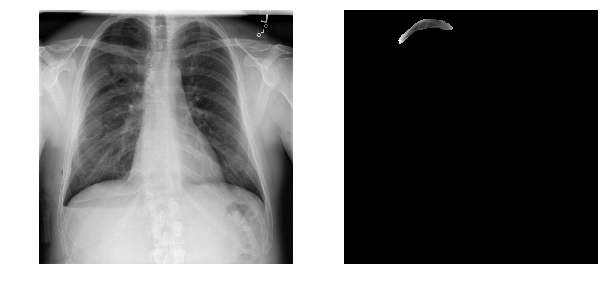

In [22]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

del masked

## Image Augmentation
Try finetuning some variables to custom values

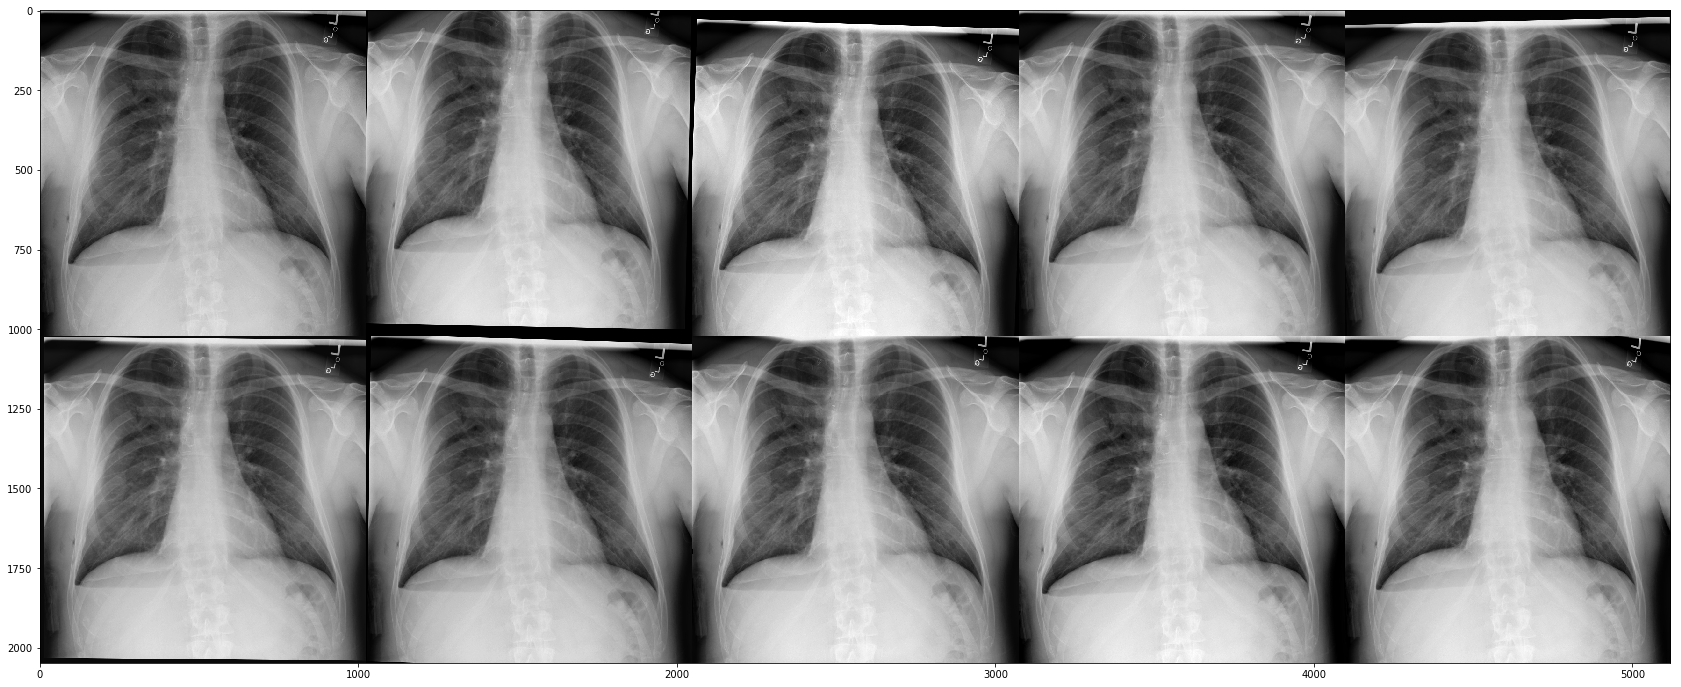

In [23]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')
del imggrid; del image

## Training
Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to a few epochs, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [24]:
%%time
# get pixel statistics
image_stats = []
for image_id in dataset_val.image_ids[:4]:
    image = dataset_val.load_image(image_id)
    image_stats.append(image.mean(axis=(0,1)))

config.MEAN_PIXEL = np.mean(image_stats, axis=0).tolist()
# VAR_PIXEL = images.var()
del image; del image_stats
gc.collect()

print(config.MEAN_PIXEL)

[116.78192591667175, 116.78192591667175, 116.78192591667175]
CPU times: user 280 ms, sys: 8 ms, total: 288 ms
Wall time: 299 ms


In [25]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# load all weights as number of classes matches the pre-trained model
model.load_weights(WEIGHTS_PATH, by_name=True)

# # Exclude the last layers because they require a matching number of classes
# model.load_weights(WEIGHTS_PATH, by_name=True,
#                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [26]:
# Train the Mask-RCNN Model
LEARNING_RATE = 0.0006

In [27]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=1,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0012

Checkpoint Path: /kaggle/working/pneumothorax20190725T1517/mask_rcnn_pneumothorax_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_ma

In [28]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=3 if debug else 13,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 1. LR=0.0006

Checkpoint Path: /kaggle/working/pneumothorax20190725T1517/mask_rcnn_pneumothorax_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

In [29]:
# %%time
# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE/2,
#             epochs=4 if debug else 18,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

In [30]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,4.016251,0.576665,0.382163,1.671176,0.431321,0.954858,4.867614,0.884077,0.536598,1.876646,0.500593,1.069632
2,3.670771,0.459085,0.351669,1.555043,0.411620,0.893259,4.010881,0.542068,0.403093,1.711732,0.436144,0.917748
3,3.679339,0.432562,0.347663,1.600529,0.417283,0.881205,3.765333,0.455736,0.352430,1.669640,0.419103,0.868327
4,3.568432,0.386074,0.311173,1.627205,0.410988,0.832895,3.651157,0.452506,0.349465,1.588144,0.417972,0.842973
5,3.507302,0.388732,0.315562,1.574861,0.404458,0.823592,3.480075,0.420713,0.338344,1.506946,0.398976,0.815000
6,3.248526,0.369019,0.309644,1.390262,0.399129,0.780375,3.356619,0.363212,0.319589,1.471629,0.397721,0.804371
7,3.470199,0.383126,0.310376,1.566548,0.397364,0.812688,3.309233,0.375023,0.351745,1.416989,0.390063,0.775317
8,3.092739,0.332094,0.328264,1.311814,0.371943,0.748527,3.228551,0.353081,0.329602,1.390109,0.381902,0.773760
9,3.116908,0.360686,0.328839,1.289619,0.373747,0.763920,3.130190,0.339143,0.337207,1.331548,0.370758,0.751436
10,3.151715,0.356063,0.310067,1.363194,0.379306,0.742989,3.024384,0.306190,0.303415,1.316591,0.364747,0.733344


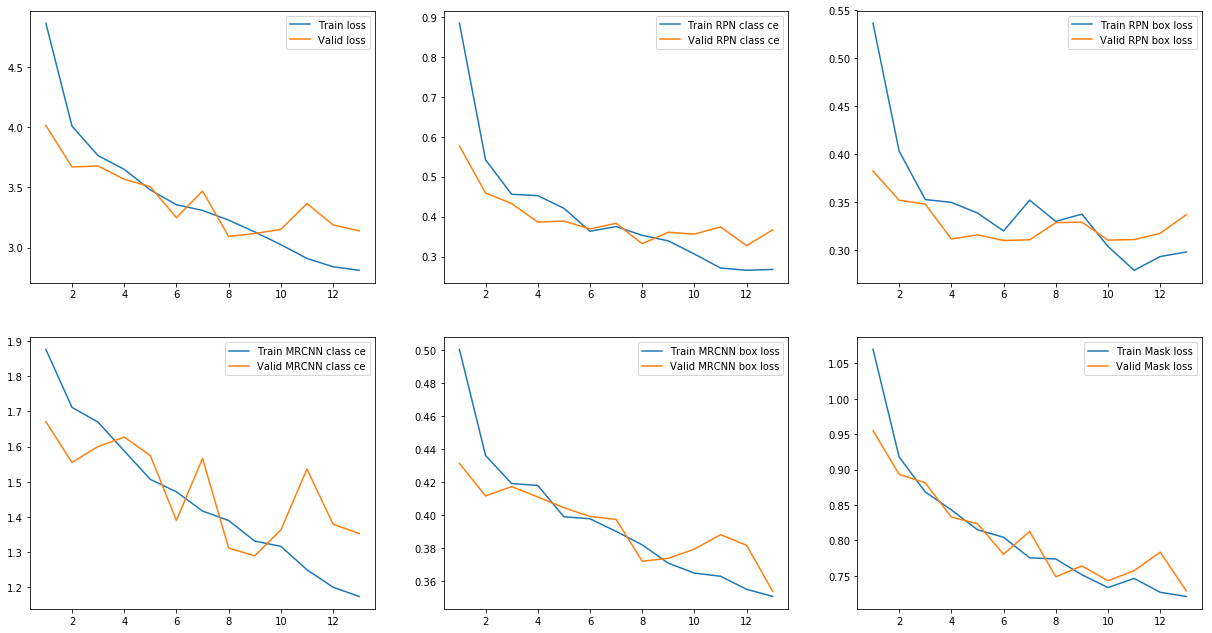

In [31]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [32]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:8 val_loss:3.092738854885101


In [33]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find checkpoints
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        raise Exception(f'No weight files in {dir_name}')
    if best_epoch < len(checkpoints):
        checkpoint = checkpoints[best_epoch]
    else:
        checkpoint = checkpoints[-1]
    fps.append(os.path.join(dir_name, checkpoint))

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumothorax20190725T1517/mask_rcnn_pneumothorax_0008.h5


In [34]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumothorax20190725T1517/mask_rcnn_pneumothorax_0008.h5
Re-starting from epoch 8


In [35]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

## Validation
How does the predicted box compared to the expected value? Let's use the validation dataset to check. 


*** No instances to display *** 



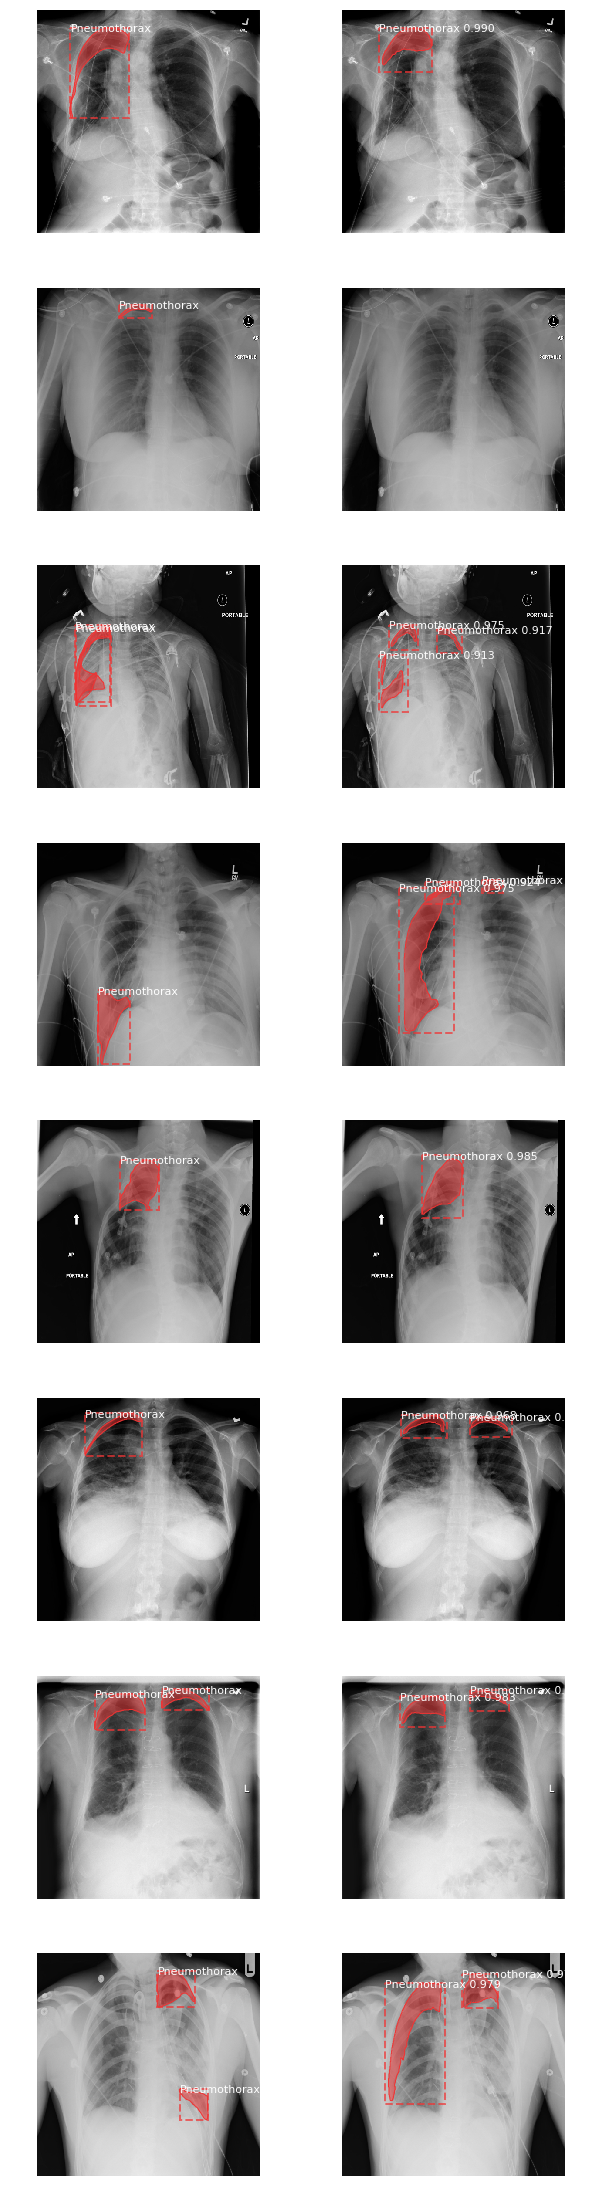

In [36]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
pneumothorax_ids_val = [fp.split('/')[-1][:-4] for fp in image_fps_val]
pneumothorax_ids_val = [i for i,id in enumerate(pneumothorax_ids_val) if id in pneumothorax_anns]
fig = plt.figure(figsize=(10, 40))

for i in range(8):
    image_id = random.choice(pneumothorax_ids_val)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

## Basic Model Weigths Analysis

In [37]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)
### Click to expand output

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_1/kernel:0,"(7, 7, 3, 64)",-0.8725,+0.8460,+0.1328
conv1_1/bias:0,"(64,)",-0.0004,+0.0004,+0.0002
bn_conv1_1/gamma:0,"(64,)",+0.0835,+2.6693,+0.5142
bn_conv1_1/beta:0,"(64,)",-2.3912,+5.3410,+1.9753
bn_conv1_1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1_1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a_1/kernel:0,"(1, 1, 64, 64)",-0.6756,+0.3334,+0.0778
res2a_branch2a_1/bias:0,"(64,)",-0.0055,+0.0115,+0.0030
bn2a_branch2a_1/gamma:0,"(64,)",+0.2169,+1.8515,+0.4131
bn2a_branch2a_1/beta:0,"(64,)",-2.1180,+3.7376,+1.1780


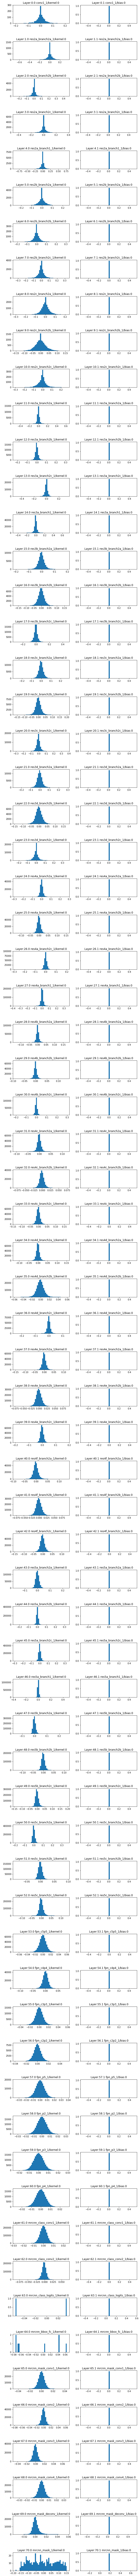

In [38]:
# from https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_weights.ipynb
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                     layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)), gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(f'Layer:{l}.{w} {tensor.name}')
        _ = ax[l, w].hist(weight[w].flatten(), 50)

## Final steps
Create the submission file

In [39]:
# Make predictions on test images, write out submission file
def predict(image_fps, filepath='submission.csv', min_conf=0.97):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for fp in tqdm_notebook(image_fps):
            image_id = fp.split('/')[-1][:-4]
            maks_written = 0
            
            ds = pydicom.read_file(fp)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            results = model.detect([image])
            r = results[0]

#             assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            num_instances = len(r['rois'])

            for i in range(num_instances):
                if r['scores'][i] > min_conf and np.sum(r['masks'][...,i]) > 1:
                    mask = r['masks'][...,i].T*255
                    mask, _,_,_,_ = utils.resize_image(
                        np.stack((mask,) * 3, -1), # requires 3 channels
                        min_dim=ORIG_SIZE,
                        min_scale=config.IMAGE_MIN_SCALE,
                        max_dim=ORIG_SIZE,
                        mode=config.IMAGE_RESIZE_MODE)
                    mask = (mask[...,0] > 0)*255
#                     print(mask.shape)
#                     plt.imshow(mask, cmap=get_cmap('jet'))
                    file.write(image_id + "," + mask2rle(mask, ORIG_SIZE, ORIG_SIZE) + "\n")
                    maks_written += 1

            if maks_written == 0:
                file.write(image_id + ",-1\n")  ## no pneumothorax

In [40]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)


/kaggle/working/submission.csv


In [41]:
sub = pd.read_csv(submission_fp, dtype={'ImageId':str, 'EncodedPixels':str})
print((sub.EncodedPixels != '-1').sum(), sub.ImageId.size, sub.ImageId.nunique())
print(sub.EncodedPixels.nunique(), (sub.EncodedPixels != '-1').sum()/sub.ImageId.nunique())

print('Unique samples:\n', sub.EncodedPixels.drop_duplicates()[:6])
sub.head(10)

89 1379 1377
90 0.06463326071169208
Unique samples:
 0     662755 4 8 8 4 12 988 4 8 8 4 12 978 54 970 54...
1                                                    -1
17    255519 70 954 70 914 126 898 126 860 174 850 1...
25    649027 36 988 36 972 60 964 60 950 78 946 78 9...
39    552343 24 1000 24 994 38 986 38 982 46 64 38 8...
48    501019 18 1006 18 992 34 990 34 984 44 980 44 ...
Name: EncodedPixels, dtype: object


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,662755 4 8 8 4 12 988 4 8 8 4 12 978 54 970 54...
1,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,-1
4,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,-1
5,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.5804.151787519...,-1
9,1.2.276.0.7230010.3.1.4.8323329.5805.151787519...,-1


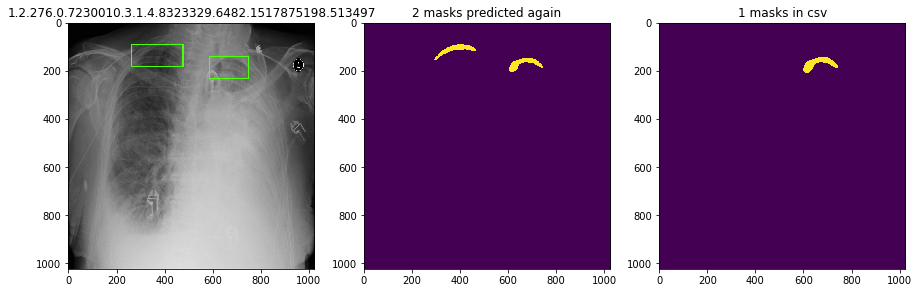

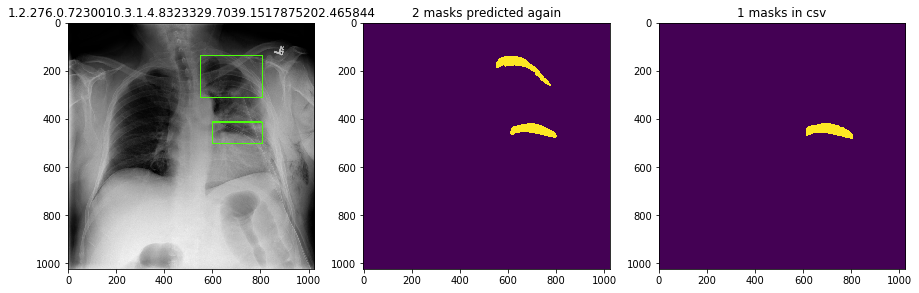

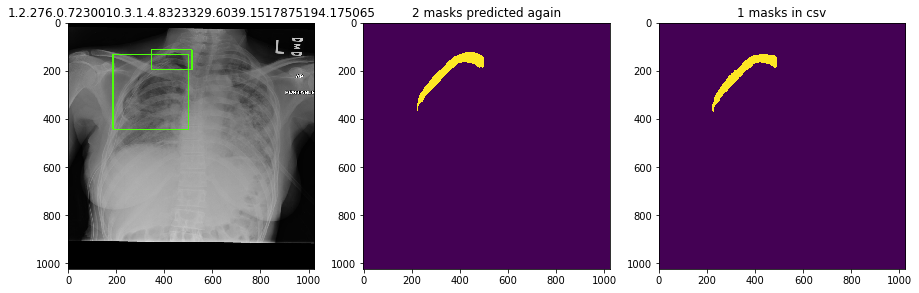

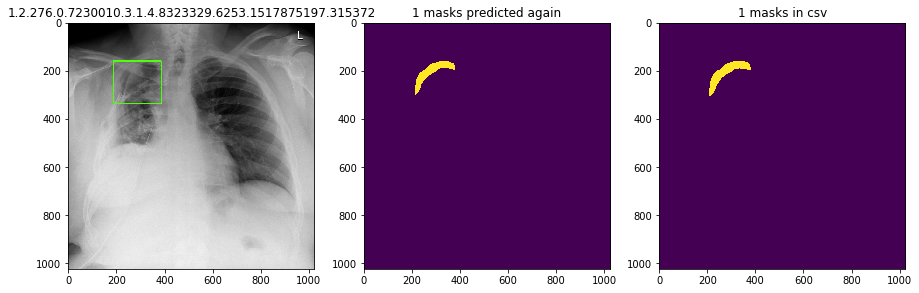

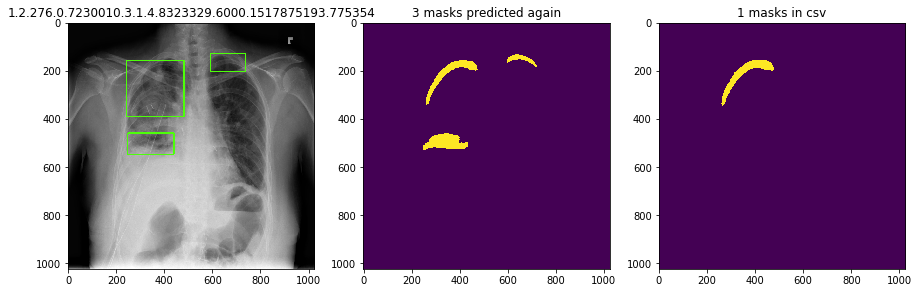

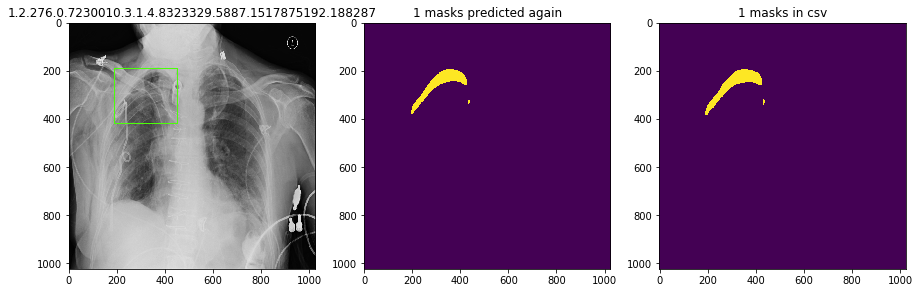

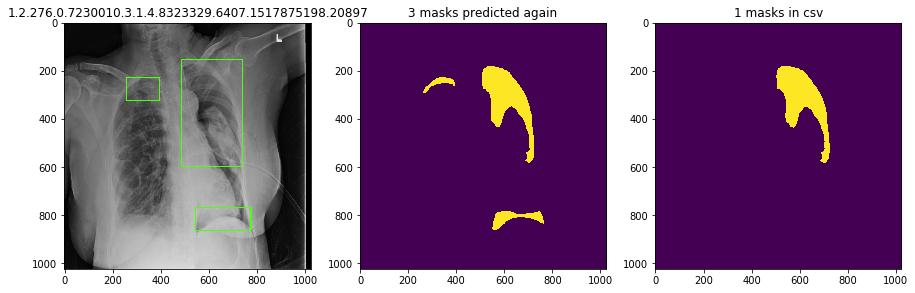

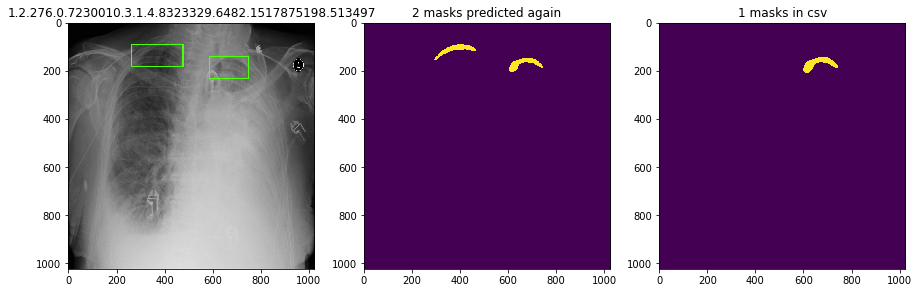

In [42]:
# show a few test image detection example
def visualize_test():
    ids_with_mask = sub[sub.EncodedPixels != '-1'].ImageId.values
    fp = random.choice([fp for fp in test_image_fps if fp.split('/')[-1][:-4] in ids_with_mask])
#     import pdb; pdb.set_trace()
    
    # original image
    image_id = fp.split('/')[-1][:-4]
    ds = pydicom.read_file(fp)
    image = ds.pixel_array
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]

    # Detect on full size test images (without resizing)
    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1
        height = y2 - y1
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_title(image_id)
    ax1.imshow(image)
    ax2.set_title(f"{len(r['rois'])} masks predicted again")
    if len(r['rois']) > 0:
        ax2.imshow(r['masks'].max(-1))  # get max (overlap) between all masks in this prediction
    ax3.set_title(f"{np.count_nonzero(image_id == ids_with_mask)} masks in csv")
    ax3.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels'].values, (ORIG_SIZE, ORIG_SIZE)))
#     print(f"ImageId=='{image_id}'", sub.query(f"ImageId=='{image_id}'")['EncodedPixels'])

for i in range(8):
    visualize_test()

In [43]:
os.chdir(ROOT_DIR)
!ls *

__notebook__.ipynb  __output__.json  submission.csv

pneumothorax20190725T1517:
events.out.tfevents.1564067881.b7ba8f1ee557  mask_rcnn_pneumothorax_0007.h5
events.out.tfevents.1564069427.b7ba8f1ee557  mask_rcnn_pneumothorax_0008.h5
mask_rcnn_pneumothorax_0001.h5		     mask_rcnn_pneumothorax_0009.h5
mask_rcnn_pneumothorax_0002.h5		     mask_rcnn_pneumothorax_0010.h5
mask_rcnn_pneumothorax_0003.h5		     mask_rcnn_pneumothorax_0011.h5
mask_rcnn_pneumothorax_0004.h5		     mask_rcnn_pneumothorax_0012.h5
mask_rcnn_pneumothorax_0005.h5		     mask_rcnn_pneumothorax_0013.h5
mask_rcnn_pneumothorax_0006.h5


In [44]:
# remove files to allow committing (hit files limit otherwise)
!rm -rf {STAGE_DIR}  /kaggle/working/*/events*